In [37]:
import torch 
from torch.utils.data import Dataset, DataLoader
from pathlib import Path
import json
import cv2
import numpy as np
from PIL import Image
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from typing import Tuple, List, Dict
import random
from tqdm import tqdm

import torch
import torch.nn as nn
import torchvision.models as models

In [38]:
class AnimeFrameDataset(Dataset):
    def __init__(self, video_dir: str, json_dir: str, 
                 clip_length: int = 30, fps: int = 8, 
                 split: str = 'train', seed: int = 42):
        """Same docstring as before"""
        self.video_dir = Path(video_dir)
        self.json_dir = Path(json_dir)
        self.clip_length = clip_length
        self.fps = fps
        self.frames_per_clip = clip_length * fps
        
        random.seed(seed)
        
        # Get sorted list of all video files
        self.video_files = sorted(list(self.video_dir.glob('*.mp4')))
        
        # Split data
        random.shuffle(self.video_files)
        n_videos = len(self.video_files)
        train_idx = int(0.8 * n_videos)
        val_idx = int(0.9 * n_videos)
        
        if split == 'train':
            self.video_files = self.video_files[:train_idx]
        elif split == 'val':
            self.video_files = self.video_files[train_idx:val_idx]
        else:  # test
            self.video_files = self.video_files[val_idx:]
            
        # Load all annotations
        self.annotations = {}
        for video_file in self.video_files:
            json_file = self.json_dir / f"{video_file.stem}.json"
            if not json_file.exists():
                print(f"Warning: Missing JSON for {video_file.stem}")
                continue
            with open(json_file, 'r') as f:
                self.annotations[video_file.stem] = json.load(f)
        
        # Setup transforms first so _create_balanced_clips can use it
        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Resize((224, 224)),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                              std=[0.229, 0.224, 0.225])
        ])
        
        # Create balanced clips with debug info
        print(f"Creating clips for {len(self.video_files)} videos...")
        self.clips = self._create_balanced_clips()
        
    def _create_balanced_clips(self) -> List[Tuple[Path, float]]:
        """Creates balanced list of (video_path, start_time) clips"""
        intro_clips = []
        outro_clips = []
        regular_clips = []
        transition_clips = []
        
        for video_file in tqdm(self.video_files, desc="Creating clips"):
            if video_file.stem not in self.annotations:
                continue
                
            ann = self.annotations[video_file.stem]
            try:
                duration = self._get_video_duration(video_file)
            except:
                print(f"Warning: Could not read duration for {video_file}")
                continue

            # Debug print
            print(f"\nProcessing {video_file.stem}:")
            print(f"Duration: {duration:.2f}s")
            print(f"Annotations: {ann}")
                
            # Sample intro clips
            if 'intro_start' in ann and 'intro_end' in ann:
                start = ann['intro_start']
                end = ann['intro_end']
                if start > self.clip_length/2:
                    transition_clips.append((video_file, max(0, start - self.clip_length/2)))
                
                # Sample from middle of intro with error handling
                try:
                    intro_times = np.arange(start + 5, end - self.clip_length, self.clip_length/2)
                    intro_clips.extend((video_file, t) for t in intro_times)
                except ValueError as e:
                    print(f"Warning: Error sampling intro clips: {e}")
                
                if end + self.clip_length/2 < duration:
                    transition_clips.append((video_file, end - self.clip_length/2))
            
            # Sample outro clips
            if 'outro_start' in ann and 'outro_end' in ann:
                start = ann['outro_start']
                end = min(ann['outro_end'], duration)  # Ensure we don't exceed duration
                if start > self.clip_length/2:
                    transition_clips.append((video_file, max(0, start - self.clip_length/2)))
                
                try:
                    outro_times = np.arange(start + 5, end - self.clip_length, self.clip_length/2)
                    outro_clips.extend((video_file, t) for t in outro_times)
                except ValueError as e:
                    print(f"Warning: Error sampling outro clips: {e}")
            
            # Sample regular clips
            regular_start = ann.get('intro_end', 0)
            regular_end = ann.get('outro_start', duration)
            if regular_end > regular_start:
                try:
                    regular_times = np.arange(regular_start + 5, regular_end - self.clip_length, 
                                           self.clip_length * 2)
                    regular_clips.extend((video_file, t) for t in regular_times)
                except ValueError as e:
                    print(f"Warning: Error sampling regular clips: {e}")

        # Print statistics before balancing
        print("\nBefore balancing:")
        print(f"Intro clips: {len(intro_clips)}")
        print(f"Outro clips: {len(outro_clips)}")
        print(f"Regular clips: {len(regular_clips)}")
        print(f"Transition clips: {len(transition_clips)}")
        
        # Balance dataset with minimum available clips
        min_clips = min(
            max(len(intro_clips) // 2, 1),
            max(len(outro_clips) // 2, 1),
            max(len(transition_clips), 1)
        )
        
        balanced_clips = (
            random.sample(intro_clips, min(len(intro_clips), min_clips * 2)) +
            random.sample(outro_clips, min(len(outro_clips), min_clips * 2)) +
            random.sample(transition_clips, min(len(transition_clips), min_clips)) +
            random.sample(regular_clips, min(len(regular_clips), min_clips * 4))
        )
        
        # Print final statistics
        print("\nAfter balancing:")
        print(f"Total clips: {len(balanced_clips)}")
        
        random.shuffle(balanced_clips)
        return balanced_clips
    
    def _get_video_duration(self, video_path: Path) -> float:
        """Get video duration in seconds"""
        cap = cv2.VideoCapture(str(video_path))
        fps = cap.get(cv2.CAP_PROP_FPS)
        frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        cap.release()
        return frame_count / fps
    
    def _load_frames(self, video_path: Path, start_time: float) -> torch.Tensor:
        """Load sequence of frames from video"""
        frames = []
        cap = cv2.VideoCapture(str(video_path))
        
        # Set starting position
        cap.set(cv2.CAP_PROP_POS_MSEC, start_time * 1000)
        
        for _ in range(self.frames_per_clip):
            ret, frame = cap.read()
            if not ret:
                break
                
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frame = Image.fromarray(frame)
            frame = self.transform(frame)
            frames.append(frame)
            
            # Skip frames to maintain desired FPS
            for _ in range(int(cap.get(cv2.CAP_PROP_FPS) / self.fps) - 1):
                cap.read()
                
        cap.release()
        
        # Pad sequence if needed
        while len(frames) < self.frames_per_clip:
            frames.append(torch.zeros_like(frames[0]))
            
        return torch.stack(frames)
    
    def _get_labels(self, video_file: Path, start_time: float) -> torch.Tensor:
        """Generate frame-level labels"""
        ann = self.annotations[video_file.stem]
        times = np.linspace(start_time, 
                          start_time + self.clip_length, 
                          self.frames_per_clip)
        labels = torch.zeros((self.frames_per_clip, 3))
        
        for i, t in enumerate(times):
            if ann.get('intro_start', float('inf')) <= t <= ann.get('intro_end', -float('inf')):
                labels[i, 0] = 1  # intro
            elif ann.get('outro_start', float('inf')) <= t <= ann.get('outro_end', -float('inf')):
                labels[i, 2] = 1  # outro
            else:
                labels[i, 1] = 1  # regular content
                
        return labels
    
    def __len__(self) -> int:
        return len(self.clips)
    
    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, torch.Tensor]:
        video_file, start_time = self.clips[idx]
        frames = self._load_frames(video_file, start_time)
        labels = self._get_labels(video_file, start_time)
        return frames, labels




In [39]:
def visualize_clip(dataset: AnimeFrameDataset, idx: int = 1021) -> None:
    """Visualize frames from a random or specified clip with labels"""
    if idx is None:
        idx = random.randint(0, len(dataset) - 1)
    
    frames, labels = dataset[idx]
    video_file, start_time = dataset.clips[idx]
    
    # Select 3 evenly spaced frames
    n_frames = frames.shape[0]
    frame_indices = [n_frames//4, n_frames//2, 3*n_frames//4]
    
    plt.figure(figsize=(15, 5))
    for i, frame_idx in enumerate(frame_indices):
        plt.subplot(1, 3, i+1)
        
        # Convert tensor to image
        frame = frames[frame_idx].permute(1, 2, 0)
        frame = frame * torch.tensor([0.229, 0.224, 0.225]) + torch.tensor([0.485, 0.456, 0.406])
        frame = frame.clip(0, 1).numpy()
        
        plt.imshow(frame)
        frame_time = start_time + frame_idx/dataset.fps
        label_idx = labels[frame_idx].argmax().item()
        label_name = ['Intro', 'Regular', 'Outro'][label_idx]
        
        plt.title(f'Time: {frame_time:.2f}s\nLabel: {label_name}')
        plt.axis('off')
    
    plt.suptitle(f'Video: {video_file.stem}')
    plt.tight_layout()
    plt.show()

In [40]:
def analyze_dataset(dataset: AnimeFrameDataset) -> Dict:
    """Analyze dataset statistics"""
    label_counts = torch.zeros(3)
    clip_types = {'intro': 0, 'outro': 0, 'regular': 0, 'transition': 0}
    
    for frames, labels in tqdm(dataset, desc="Analyzing dataset"):
        label_indices = labels.argmax(dim=1)
        unique_labels = torch.unique(label_indices)
        
        # Count frame labels
        for i in range(3):
            label_counts[i] += (label_indices == i).sum().item()
            
        # Categorize clip type
        if len(unique_labels) > 1:
            clip_types['transition'] += 1
        elif 0 in unique_labels:
            clip_types['intro'] += 1
        elif 2 in unique_labels:
            clip_types['outro'] += 1
        else:
            clip_types['regular'] += 1
    
    return {
        'total_clips': len(dataset),
        'total_frames': label_counts.sum().item(),
        'label_distribution': {
            'intro': label_counts[0].item(),
            'regular': label_counts[1].item(),
            'outro': label_counts[2].item()
        },
        'clip_types': clip_types
    }

In [41]:
def test_dataset(video_dir, json_dir):
    """Test dataset creation with specified paths"""
    print(f"Testing dataset creation...")
    print(f"Video directory: {video_dir}")
    print(f"JSON directory: {json_dir}")
    
    try:
        dataset = AnimeFrameDataset(
            video_dir=video_dir,
            json_dir=json_dir,
            split='train'
        )
        
        print(f"\nDataset created successfully!")
        print(f"Total clips: {len(dataset)}")
        
        if len(dataset) > 0:
            frames, labels = dataset[0]
            print(f"Sample shapes:")
            print(f"- Frames: {frames.shape}")
            print(f"- Labels: {labels.shape}")
            
            # Test visualization
            visualize_clip(dataset)
            
        return dataset
        
    except Exception as e:
        print(f"Error creating dataset: {str(e)}")
        raise

Testing dataset creation...
Video directory: /teamspace/studios/this_studio/100anime
JSON directory: /teamspace/studios/this_studio/100 anime
Creating clips for 82 videos...


Creating clips:  18%|█▊        | 15/82 [00:00<00:00, 144.14it/s]


Processing 43:
Duration: 1437.06s
Annotations: {'intro_start': 120.28683333333332, 'intro_end': 210.41854166666664, 'outro_start': 1332.4144166666665, 'outro_end': 1422.2958749999998}

Processing 77:
Duration: 1439.98s
Annotations: {'intro_start': 164.83133333333333, 'intro_end': 255.67208333333332, 'outro_start': 1345.3857083333332, 'outro_end': 1438.6038333333333}

Processing 80:
Duration: 1420.96s
Annotations: {'intro_start': 348.3897083333333, 'intro_end': 437.89579166666664, 'outro_start': 1246.0781666666667, 'outro_end': 1337.5862499999998}

Processing 14:
Duration: 1465.09s
Annotations: {'intro_start': 139.72291666666666, 'intro_end': 216.5079583333333, 'outro_start': 1354.9369166666665, 'outro_end': 1445.9444999999998}

Processing 67:
Duration: 1440.02s
Annotations: {'intro_start': 43.58520833333333, 'intro_end': 137.17870833333333, 'outro_start': 1349.6816666666666, 'outro_end': 1397.521125}

Processing 49:
Duration: 1555.10s
Annotations: {'intro_start': 1.0427083333333333, '

Creating clips:  55%|█████▍    | 45/82 [00:00<00:00, 121.22it/s]


Processing 3:
Duration: 1420.04s
Annotations: {'intro_start': 134.759625, 'intro_end': 225.80891666666665, 'outro_start': 1413.0783333333331, 'outro_end': 1414.6215416666666}

Processing 78:
Duration: 1555.05s
Annotations: {'intro_start': 15.348666666666666, 'intro_end': 109.48437499999999, 'outro_start': 1445.0686249999999, 'outro_end': 1545.1686249999998}

Processing 53:
Duration: 1440.11s
Annotations: {'intro_start': 47.79774999999999, 'intro_end': 144.769625, 'outro_start': 1350.3072916666665, 'outro_end': 1437.7696666666666}

Processing 92:
Duration: 1393.81s
Annotations: {'intro_start': 0.33366666666666667, 'intro_end': 94.05229166666666, 'outro_start': 1269.6016666666667, 'outro_end': 1358.357}

Processing 50:
Duration: 1534.07s
Annotations: {'intro_start': 76.5765, 'intro_end': 165.37354166666665, 'outro_start': 1350.9746249999998, 'outro_end': 1533.2400416666665}

Processing 61:
Duration: 1436.06s
Annotations: {'intro_start': 346.42941666666667, 'intro_end': 436.3942916666666

Creating clips:  85%|████████▌ | 70/82 [00:00<00:00, 115.00it/s]


Processing 12:
Duration: 1436.04s
Annotations: {'intro_start': 1.4597916666666666, 'intro_end': 91.54979166666666, 'outro_start': 1413.3494374999998, 'outro_end': 1423.6931041666667}

Processing 37:
Duration: 1453.74s
Annotations: {'intro_start': 1.4180833333333331, 'intro_end': 11.469791666666666, 'outro_start': 1429.5948333333333, 'outro_end': 1451.9922083333333}

Processing 81:
Duration: 1442.32s
Annotations: {'intro_start': 114.489375, 'intro_end': 204.2457083333333, 'outro_start': 1337.5028333333332, 'outro_end': 1425.4657083333332}

Processing 48:
Duration: 1432.18s
Annotations: {'intro_start': 91.42466666666667, 'intro_end': 182.34883333333332, 'outro_start': 1343.0500416666666, 'outro_end': 1430.7209583333333}

Processing 100:
Duration: 1435.14s
Annotations: {'intro_start': 0.04170833333333333, 'intro_end': 165.08158333333333, 'outro_start': 1395.4774166666666, 'outro_end': 1400.4774166666666}

Processing 52:
Duration: 1476.31s
Annotations: {'intro_start': 56.72333333333333, '

Creating clips: 100%|██████████| 82/82 [00:00<00:00, 117.78it/s]



Processing 95:
Duration: 1440.02s
Annotations: {'intro_start': 0.5422083333333333, 'intro_end': 165.41525, 'outro_start': 1397.521125, 'outro_end': 1402.3592916666666}

Processing 58:
Duration: 1461.00s
Annotations: {'intro_start': 115.90745833333332, 'intro_end': 210.16829166666665, 'outro_start': 1329.453125, 'outro_end': 1460.20875}

Processing 93:
Duration: 1437.06s
Annotations: {'intro_start': 77.66091666666667, 'intro_end': 167.33383333333333, 'outro_start': 1332.9983333333332, 'outro_end': 1421.8787916666665}

Processing 54:
Duration: 1440.06s
Annotations: {'intro_start': 58.975583333333326, 'intro_end': 151.06758333333332, 'outro_start': 1345.9279166666665, 'outro_end': 1439.1877499999998}

Processing 89:
Duration: 1389.93s
Annotations: {'intro_start': 119.61949999999999, 'intro_end': 214.17229166666664, 'outro_start': 1265.3057083333333, 'outro_end': 1355.228875}

Processing 29:
Duration: 1481.77s
Annotations: {'intro_start': 1.5014999999999998, 'intro_end': 91.50808333333333

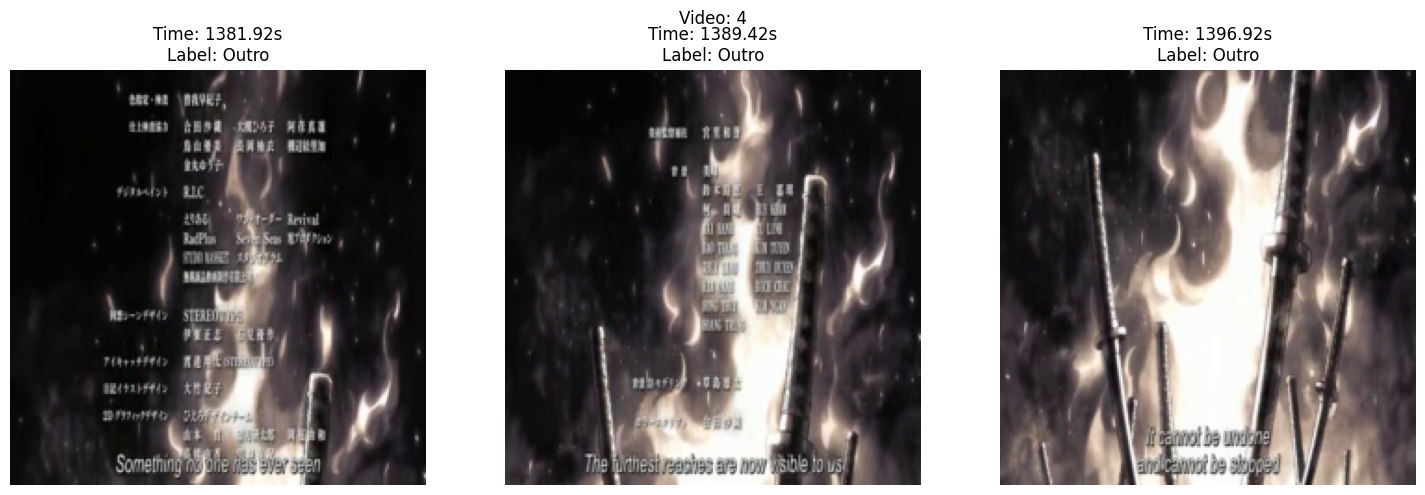

In [42]:
dataset = test_dataset(
    video_dir='/teamspace/studios/this_studio/100anime',
    json_dir='/teamspace/studios/this_studio/100 anime'
)

In [43]:
class AnimeSceneClassifier(nn.Module):
    def __init__(self, hidden_dim=256, num_layers=2, dropout=0.3):
        super().__init__()
        
        # MobileNetV2 feature extractor
        mobilenet = models.mobilenet_v2(pretrained=True)
        self.features = nn.Sequential(*list(mobilenet.children())[:-1])
        
        # Feature dimension reduction (from 1280 to hidden_dim)
        self.reduce_dim = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(1280, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout)
        )
        
        # Bidirectional GRU
        self.gru = nn.GRU(
            input_size=hidden_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            bidirectional=True,
            dropout=dropout if num_layers > 1 else 0,
            batch_first=True
        )
        
        # Classification head
        self.classifier = nn.Sequential(
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, 3)  # 3 classes: intro, regular, outro
        )

    def forward(self, x):
        batch_size, seq_len, c, h, w = x.size()
        
        # Extract features
        x = x.view(batch_size * seq_len, c, h, w)
        x = self.features(x)
        x = self.reduce_dim(x)
        
        # Reshape for GRU
        x = x.view(batch_size, seq_len, -1)
        
        # Apply GRU
        x, _ = self.gru(x)
        
        # Classify each timestep
        return self.classifier(x)

In [44]:
def test_model():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = AnimeSceneClassifier().to(device)
    
    # Test with random input
    x = torch.randn(2, 240, 3, 224, 224).to(device)  # batch_size=2, seq_len=240
    y = model(x)
    print(f"Input shape: {x.shape}")
    print(f"Output shape: {y.shape}")
    print(f"Model parameters: {sum(p.numel() for p in model.parameters()) / 1e6:.2f}M")
    
    return model

In [45]:
model = test_model()

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


: 